# Spectrum CTIO
=========================

In [273]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [375]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [274]:
from scipy import stats  
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [275]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [276]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [277]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Defines file parameters
=================================

In [278]:
path_img='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOData2016'
file_img='fileno016.fits'
object_name='fileno016'

In [279]:
fullfile=os.path.join(path_img,file_img)

## Open file
===============

In [280]:
hdu_list=fits.open(fullfile)
hdu_list.info()

Filename: /Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOData2016/fileno016.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     135   (2168, 2048)   int16 (rescales to uint16)   


## Extract image
=====================

In [281]:
image_data = hdu_list[0].data

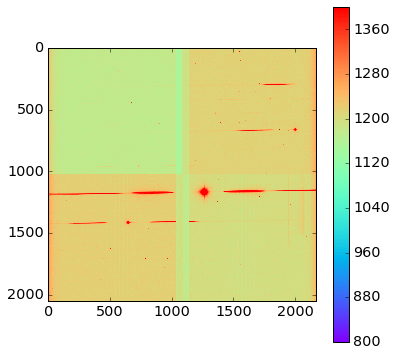

In [282]:
im=plt.imshow(image_data,cmap='rainbow',vmin=800,vmax=1400)
plt.colorbar(im)

## Find Overscan region
==============================

In [283]:
profile_x=np.average(image_data,axis=0)
profile_y=np.average(image_data,axis=1)

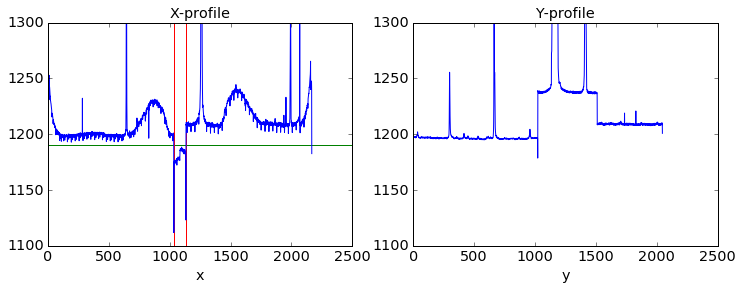

In [284]:
prof_max=1300
prof_min=1100
prof_cut=1190 # vertical cut
x_cut1=1034   # horizontal cut
x_cut2=1133   # horizontal cut
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12.,4))
ax1.plot([0,2500],[prof_cut,prof_cut],'g-') # horizontal line for the cut value
ax1.plot([x_cut1,x_cut1],[prof_min,prof_max],'r-')   # vertical line1
ax1.plot([x_cut2,x_cut2],[prof_min,prof_max],'r-')   # vertical line1
ax1.plot(profile_x)
ax1.set_ylim(prof_min,prof_max)
ax1.set_title('X-profile')
ax1.set_xlabel('x')

ax2.plot(profile_y)
ax2.set_ylim(prof_min,prof_max)
ax2.set_title('Y-profile')
ax2.set_xlabel('y')

In [285]:
np.where(profile_x<prof_cut)

(array([   0, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
        1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054,
        1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065,
        1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
        1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
        1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098,
        1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109,
        1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
        1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131,
        1132, 1133, 2167]),)

## Remove overscan region
===================================

In [286]:
image_left=image_data[:,0:x_cut1]
#image_left=image_data[:,0:x_cut1+1]
image_right=image_data[:,x_cut2+1:]
#image_right=image_data[:,x_cut2:]

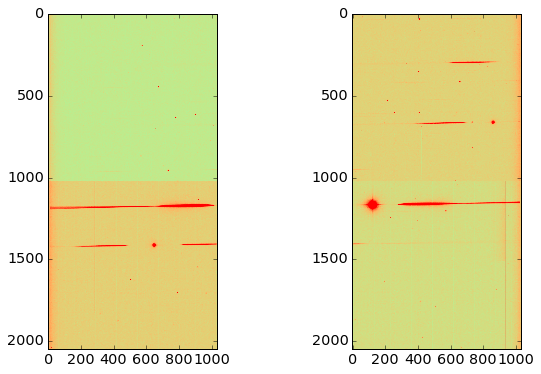

In [287]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10.,6))
im1=ax1.imshow(image_left,cmap='rainbow',vmin=800,vmax=1400)
im2=ax2.imshow(image_right,cmap='rainbow',vmin=800,vmax=1400)

In [288]:
image_glued=np.concatenate((image_left,image_right),axis=1)

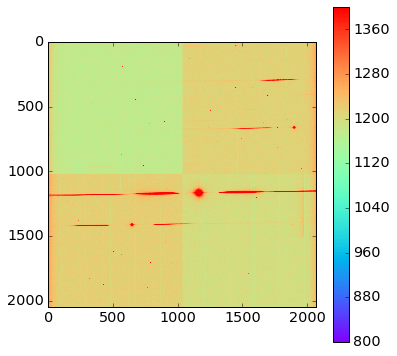

In [289]:
im=plt.imshow(image_glued,cmap='rainbow',vmin=800,vmax=1400)
plt.colorbar(im)

## Check the profile
=========================

In [290]:
profile_x=np.average(image_glued,axis=0)
profile_y=np.average(image_glued,axis=1)

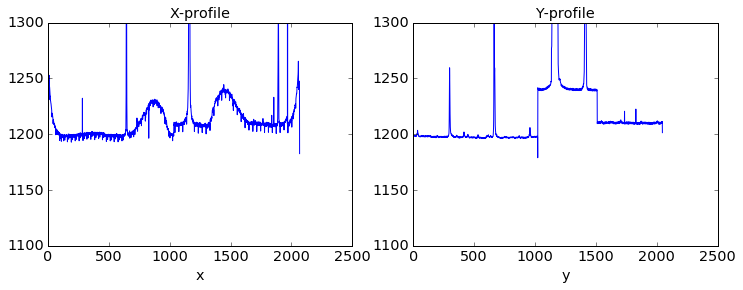

In [291]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12.,4))
ax1.plot(profile_x)
ax1.set_ylim(prof_min,prof_max)
ax1.set_title('X-profile')
ax1.set_xlabel('x')
ax2.plot(profile_y)
ax2.set_ylim(prof_min,prof_max)
ax2.set_title('Y-profile')
ax2.set_xlabel('y')

## histograms of glued image value
=============================================

In [292]:
print(type(image_glued))
print('image shape',image_glued.shape)
themin=image_glued.min()
themax=image_glued.max()
print('min and max',themin,themax)

<type 'numpy.ndarray'>
('image shape', (2048, 2068))
('min and max', 771, 62969)


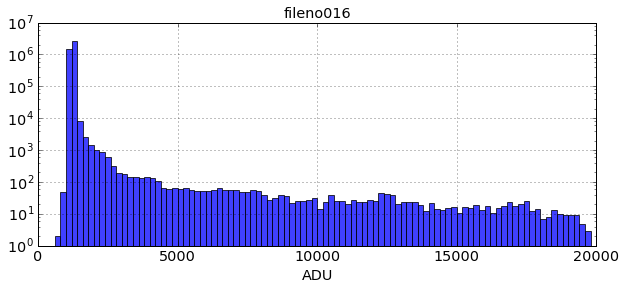

In [293]:
title=object_name
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
image_flat=image_glued.flatten()
plt.hist(image_flat,bins=100,range=(0,20000),facecolor='blue', alpha=0.75);
ax.set_title(title)
ax.set_xlabel('ADU')
#ax.set_xlim(0,20000)
ax.grid(True)
plt.yscale('log')
plt.show()

### Transfer the image in CCDData
====================================

In [294]:
ccd=ccdproc.CCDData(image_glued,unit='adu')

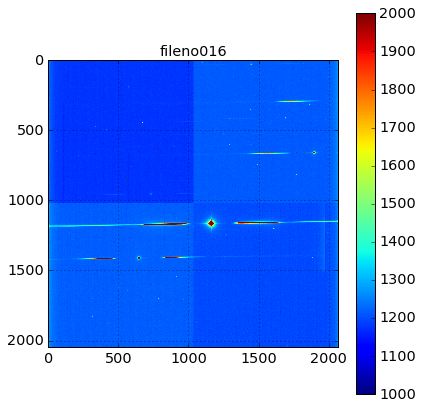

In [295]:
ig, ax = plt.subplots(figsize=(6,6))
img=ax.imshow(ccd,vmin=1000,vmax=2000.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)
plt.grid(True)
plt.savefig(object_name)

### Extraction of Background
===============================

In [296]:
sigma_clip = SigmaClip(sigma=3., iters=10)

In [297]:
bkg_estimator = MedianBackground()

In [298]:
bkg = Background2D(ccd, (70, 70), filter_size=(3, 3),method='median')
#bkg = Background2D(ccd.data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip,bkg_estimator=bkg_estimator)

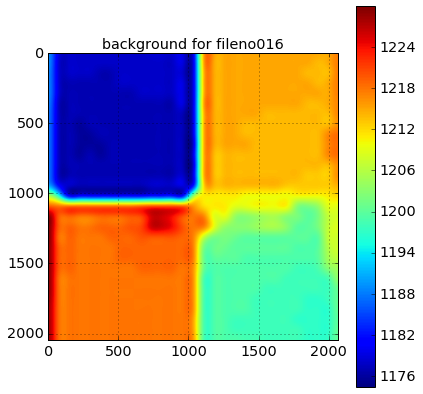

In [299]:
fig, ax = plt.subplots(figsize=(6,6))
img=ax.imshow(bkg.background)
title = 'background for '+ object_name
plt.title(title)
plt.tight_layout()
plt.colorbar(img)
plt.grid(True)

#plt.savefig()

#### Structure of the background
==================================

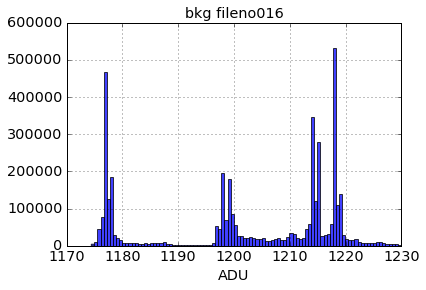

In [300]:
title='bkg '+object_name
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
bkg_data=bkg.background
bkg_flat=bkg_data.flatten()
plt.hist(bkg_flat,bins=100,facecolor='blue', alpha=0.75);
ax.set_title(title)
ax.set_xlabel('ADU')
ax.grid(True)
#plt.yscale('log')
plt.show()

In [301]:
print('median background = ',bkg.background_median)
print('median rms = ',bkg.background_rms_median)

('median background = ', 1210.0)
('median rms = ', 6.109208167652123)


### Image subtracted from background
========================================

In [302]:
ccd_bgsub=ccd - bkg.background

#### histogram of corrected image
------------------------------

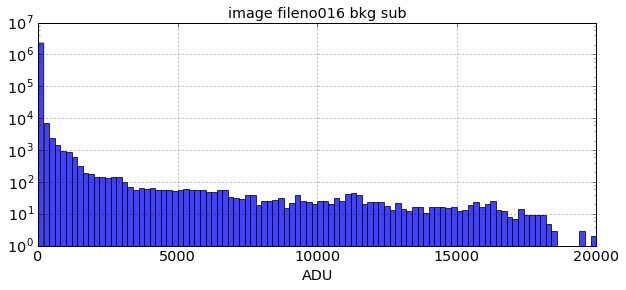

In [303]:
title='image '+object_name+' bkg sub'
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ccd_bgsub_flat=ccd_bgsub.flatten()
plt.hist(ccd_bgsub_flat,bins=100,range=(0,20000.),facecolor='blue', alpha=0.75);
ax.set_title(title)
ax.set_xlabel('ADU')
ax.grid(True)
plt.yscale('log')
plt.show()

## image corrected from background
==============================================

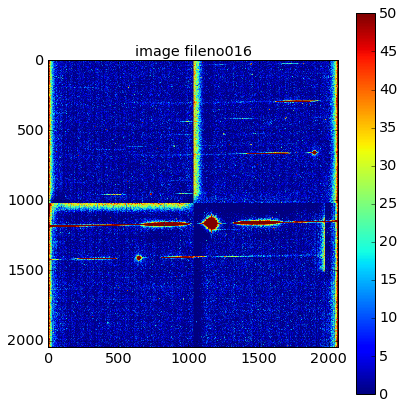

In [304]:
title='image '+object_name
fig, ax = plt.subplots(figsize=(6, 6))
img=ax.imshow(ccd_bgsub,vmin=0,vmax=50.)
plt.title(title)
plt.tight_layout()
plt.colorbar(img)
plt.grid(True)
#plt.savefig('imagebgsub')

## Rotation of the image
==========================

In [305]:
rotated_image=ndimage.interpolation.rotate(ccd_bgsub,-1)

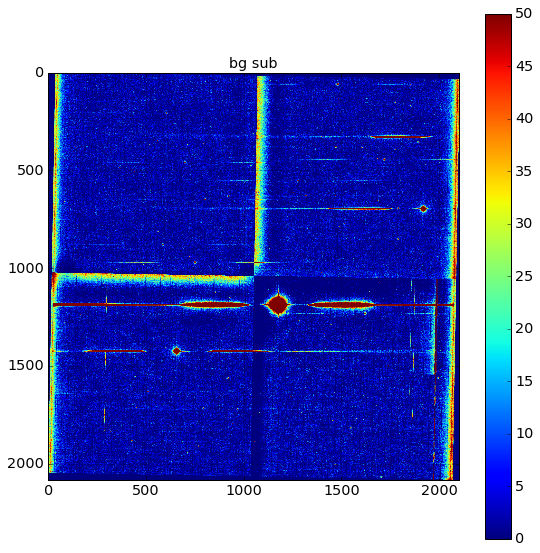

In [306]:
fig, ax = plt.subplots(figsize=(8,8))
img=ax.imshow(rotated_image,vmin=0,vmax=50.)
plt.title('bg sub')
plt.tight_layout()
plt.colorbar(img)
plt.grid(True)
#plt.savefig('imagerot')

## The maximum position

In [307]:
themaximum=rotated_image.max()

In [308]:
imax,jmax = np.unravel_index(rotated_image.argmax(),rotated_image.shape)
print imax,' ',jmax

1208   1175


In [309]:
max_index_y=rotated_image.shape[0]-1
max_index_x=rotated_image.shape[1]-1

### Extraction of spectra region
=================================

In [348]:
imax=1190    # I have chosen by hand the imax
w=10

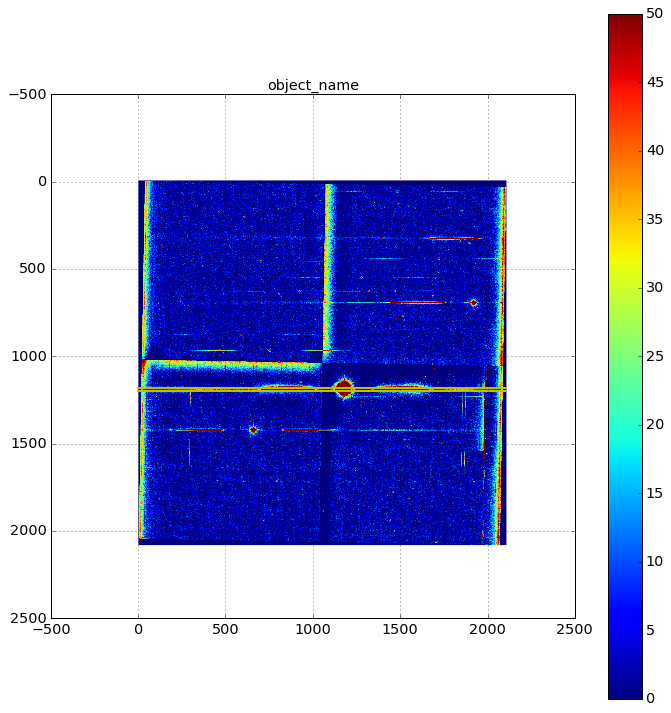

In [343]:
# check the central region is OK
# -------------------------------
fig, ax = plt.subplots(figsize=(10,10))
img=ax.imshow(rotated_image,vmin=0,vmax=50.)
plt.colorbar(img)
ax.plot([0, max_index_x], [imax-w, imax-w], color='y', linestyle='-', linewidth=2)
ax.plot([0,max_index_x], [imax+w, imax+w], color='y', linestyle='-', linewidth=2)
plt.title('object_name')
plt.tight_layout()
plt.grid(True)
#plt.savefig(outputfigfilename4)

#### Profiles of three vertical slices
-------------------------------

In [344]:
profile1=np.sum(rotated_image[:,700:1000],axis=1)  # left wing profile
profile2=np.sum(rotated_image[:,1200:1300],axis=1) # central star profile
profile3=np.sum(rotated_image[:,1300:1800],axis=1) # right wing profile 

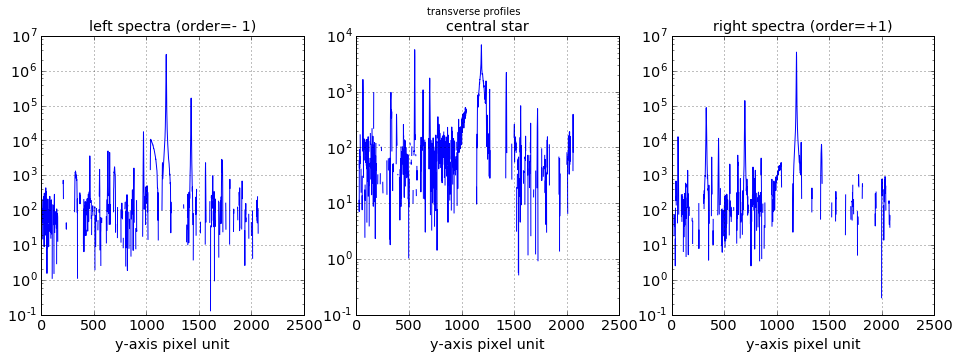

In [345]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16.,5))
ax1.semilogy(profile1)
ax2.semilogy(profile2)
ax3.semilogy(profile3)
#ax1.plot(profile1)
#ax2.plot(profile2)
#ax3.plot(profile3)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax1.set_title('left spectra (order=- 1)')
ax2.set_title('central star')
ax3.set_title('right spectra (order=+1)')
ax1.set_xlabel('y-axis pixel unit')
ax2.set_xlabel('y-axis pixel unit')
ax3.set_xlabel('y-axis pixel unit')
plt.suptitle('transverse profiles')

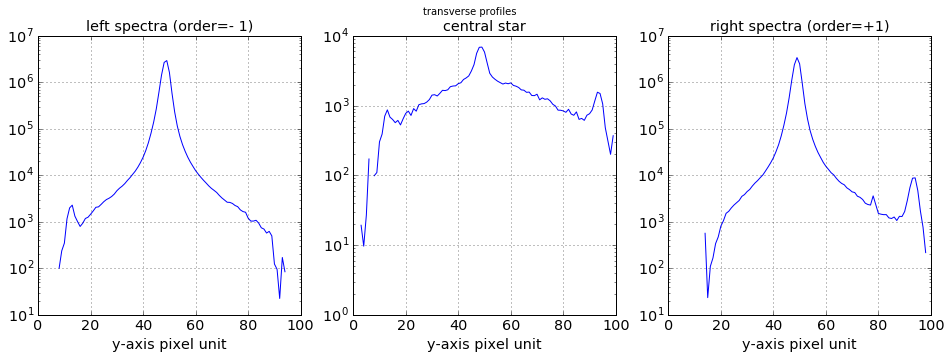

In [346]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16.,5))
ax1.semilogy(profile1[imax-5*w:imax+5*w])
ax2.semilogy(profile2[imax-5*w:imax+5*w])
ax3.semilogy(profile3[imax-5*w:imax+5*w])
#ax1.plot(profile1)
#ax2.plot(profile2)
#ax3.plot(profile3)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax1.set_title('left spectra (order=- 1)')
ax2.set_title('central star')
ax3.set_title('right spectra (order=+1)')
ax1.set_xlabel('y-axis pixel unit')
ax2.set_xlabel('y-axis pixel unit')
ax3.set_xlabel('y-axis pixel unit')
plt.suptitle('transverse profiles')

#### Extraction of spectrum region
------------------------------

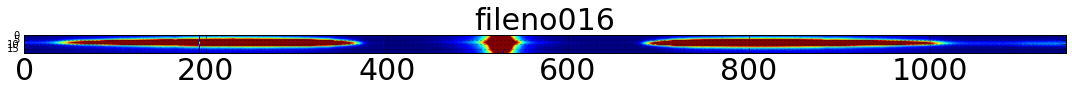

In [347]:
fig, ax = plt.subplots(figsize=(15, 10))
spectraregion=np.copy(rotated_image[imax-w:imax+w,650:1800])
spectraregionav=spectraregion/(2*w)
ax.imshow(spectraregionav,vmin=0,vmax=50.)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=10)
ax.grid(True)
plt.title(object_name,fontsize=30)
plt.tight_layout()

### Spectrum
==============

In [349]:
spectrum=np.sum(spectraregionav,axis=0)

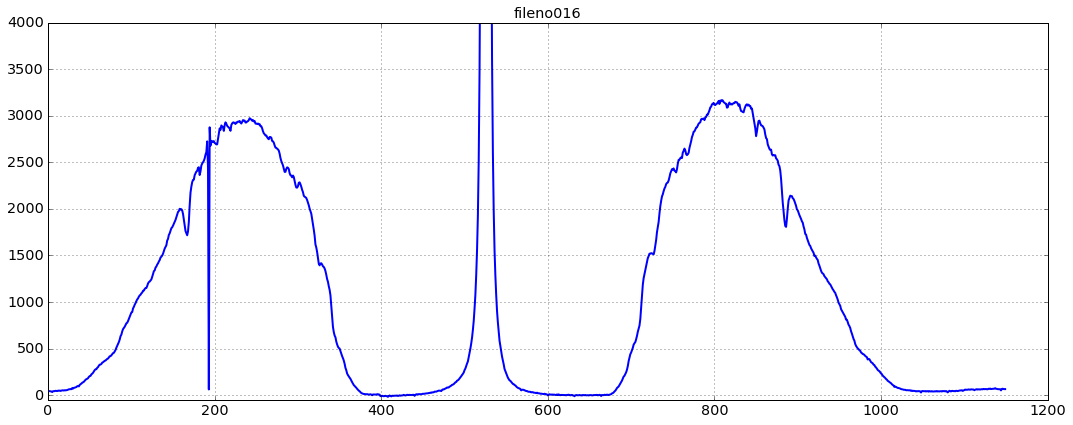

In [350]:
fig, ax = plt.subplots(figsize=(15, 6))
#plt.semilogy(spectrum)
plt.plot(spectrum,lw=2)
plt.ylim(-50.,4000.)
plt.title(object_name)
plt.tight_layout()
#plt.ylim(0.,200.)
plt.grid(True)
#plt.savefig(outputfigfilename6)


## Remove the central star

In [351]:
spectrum2=spectrum

In [352]:
spectrum2[400:600]=0

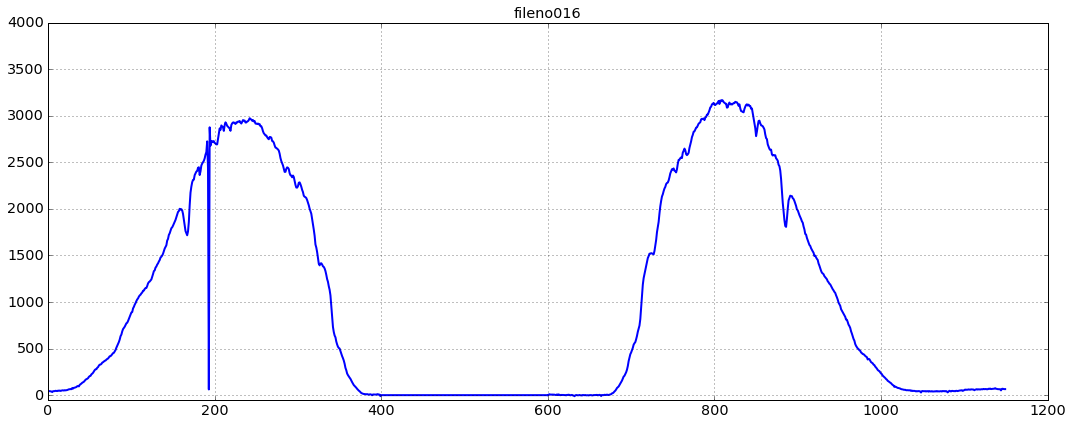

In [353]:
fig, ax = plt.subplots(figsize=(15, 6))
#plt.semilogy(spectrum)
plt.plot(spectrum2,lw=2)
plt.ylim(-50.,4000.)
plt.title(object_name)
plt.tight_layout()
#plt.ylim(0.,200.)
plt.grid(True)
#plt.savefig(outputfigfilename6)

## Split the spectrum in 2 parts

In [321]:
def GetSpectrumBackground(inspectra,start,stop,skybg):
    '''
    Return the background    
    '''
    cropedbg=inspectra[start:stop]
    purebg=cropedbg[np.where(cropedbg!=skybg)]  # remove region of the bing star
    
    return purebg

In [322]:
def SeparateSpectra(inspectra,x0):
    '''
    Cut the two spectra
    '''
    rightspectra=inspectra[x0:]
    revleftspectra=inspectra[:x0]
    leftspectra=   revleftspectra[::-1]
    #rightspectra=rightspectra[np.where(rightspectra>0)]
    #leftspectra=leftspectra[np.where(leftspectra>0)]
    
    return leftspectra,rightspectra

In [323]:
def DiffSpectra(spec1,spec2,bg):
    '''
    Make the difference of the tow spectra 
    
    '''
    N1=spec1.shape[0]
    N2=spec2.shape[0]
    N=np.min([N1,N2])
    spec1_croped=spec1[0:N]
    spec2_croped=spec2[0:N]
    diff_spec=np.average((spec1_croped-spec2_croped)**2)/bg**2
    return diff_spec  

In [354]:
spec1,spec2=SeparateSpectra(spectrum2,527)

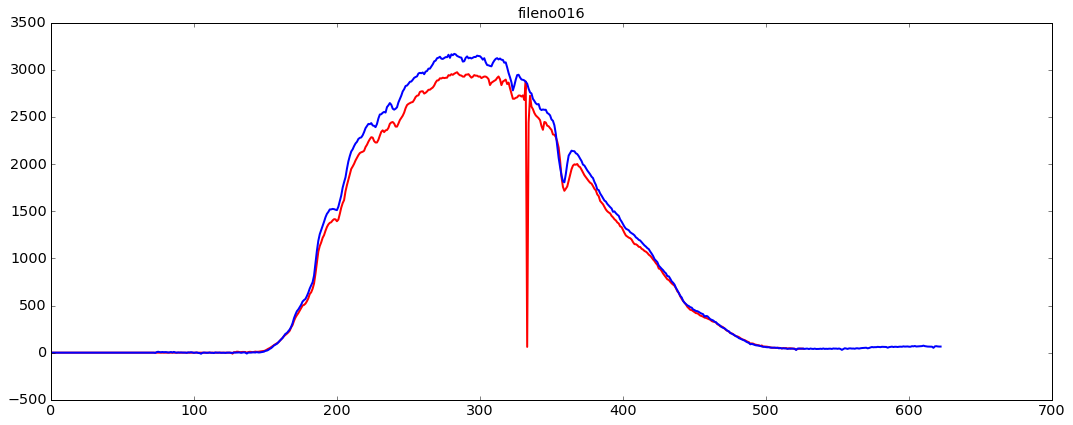

In [355]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(spec1,'r-',lw=2)
ax.plot(spec2,'b-',lw=2)
plt.title(object_name)
plt.tight_layout()
#plt.ylim(-50.,2000.)

In [356]:
def FindCenter(fullspectrum,xmin,xmax,specbg):
    '''
    '''
    
    all_x0=np.arange(xmin,xmax,1)
    NBPOINTS=np.shape(all_x0)
    chi2=np.zeros(NBPOINTS)
    for idx,x0 in np.ndenumerate(all_x0):
        spec1,spec2=SeparateSpectra(fullspectrum,x0)
        chi2[idx]=DiffSpectra(spec1,spec2,specbg)
    return all_x0,chi2

In [357]:
origins,thechi2=FindCenter(spectrum2,400,700,1)

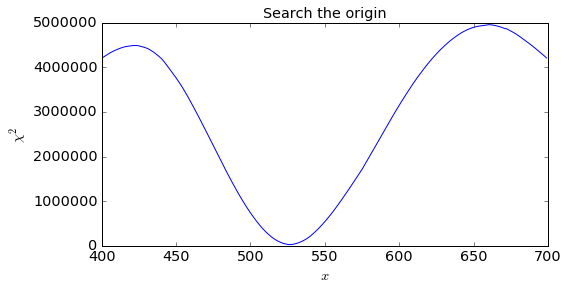

In [360]:
fig = plt.figure(figsize=(8,4))
plt.plot(origins,thechi2)
plt.title('Search the origin')
plt.ylabel('$\chi^2$')
plt.xlabel('$x$')
#plt.ylim(0,200.)

In [361]:
indexmin=np.where(thechi2==thechi2.min())[0]
theorigin=origins[indexmin]
print indexmin[0],theorigin[0],thechi2.min()

127 527 27228.060258


In [362]:
spec1,spec2=SeparateSpectra(spectrum,theorigin[0])

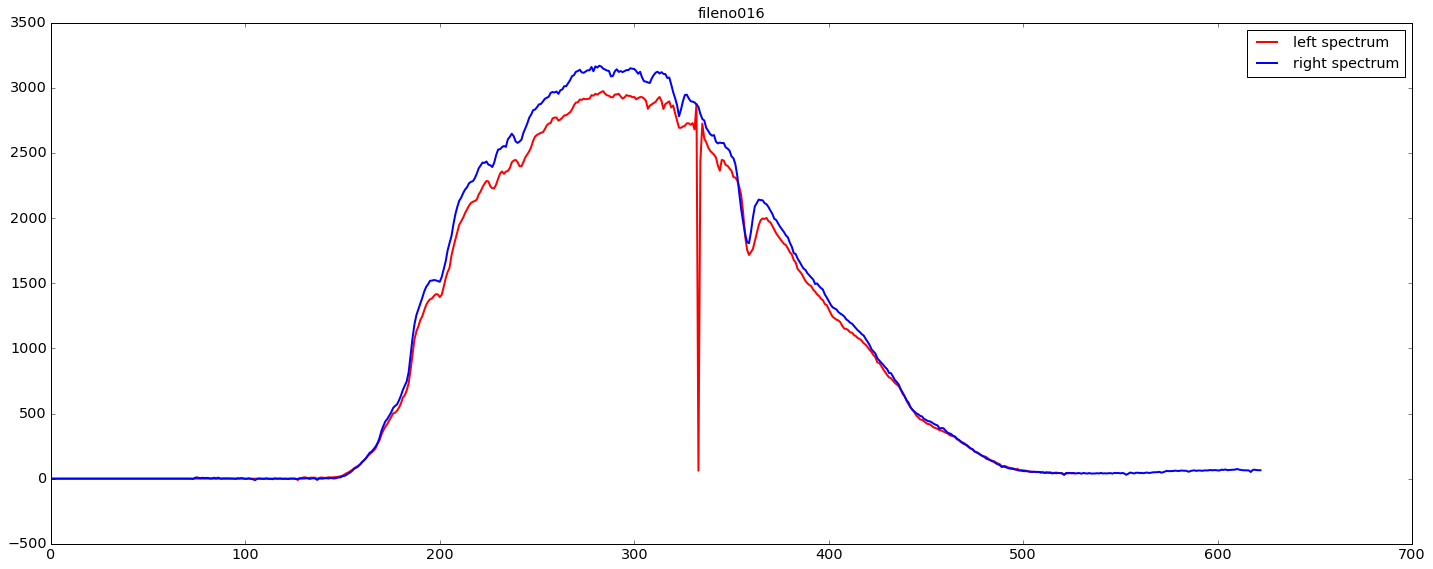

In [363]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(spec1,color='r',lw=2,label='left spectrum')
ax.plot(spec2,color='b',lw=2,label='right spectrum')
plt.title(object_name)
plt.legend(loc='best')
#plt.ylim(-50.,1500.)
plt.tight_layout()

In [364]:
bbbg1=spec1[80:150]
bbbg2=spec2[80:150]
bbbg=0.5*(bbbg1.std()+bbbg2.std())
print bbbg

4.11776228066


In [365]:
gains=np.linspace(0.5,1.5,1000)
NBGAINS=gains.shape[0]
chi2New=np.zeros(NBGAINS)

In [334]:
def DiffAmplitudes(sp1,sp2,gain,basebg):
    '''
    get the differences of the spectra for that gain
    '''    
    return DiffSpectra(sp1,gain*sp2,basebg)

In [366]:
for idx,gain in np.ndenumerate(gains):
    chi2New[idx]=DiffAmplitudes(spec1,spec2,gain,bbbg)

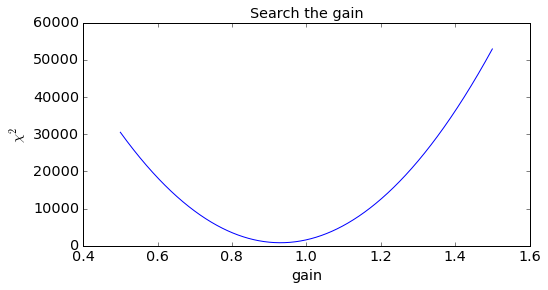

In [367]:
fig = plt.figure(figsize=(8,4))
plt.plot(gains,chi2New)
plt.title('Search the gain')
plt.xlabel('gain')
plt.ylabel('$\chi^2$')

In [368]:
thegain=gains[np.where(chi2New==chi2New.min())]

In [369]:
print thegain

[ 0.93043043]


In [370]:
spec2=spec2*thegain

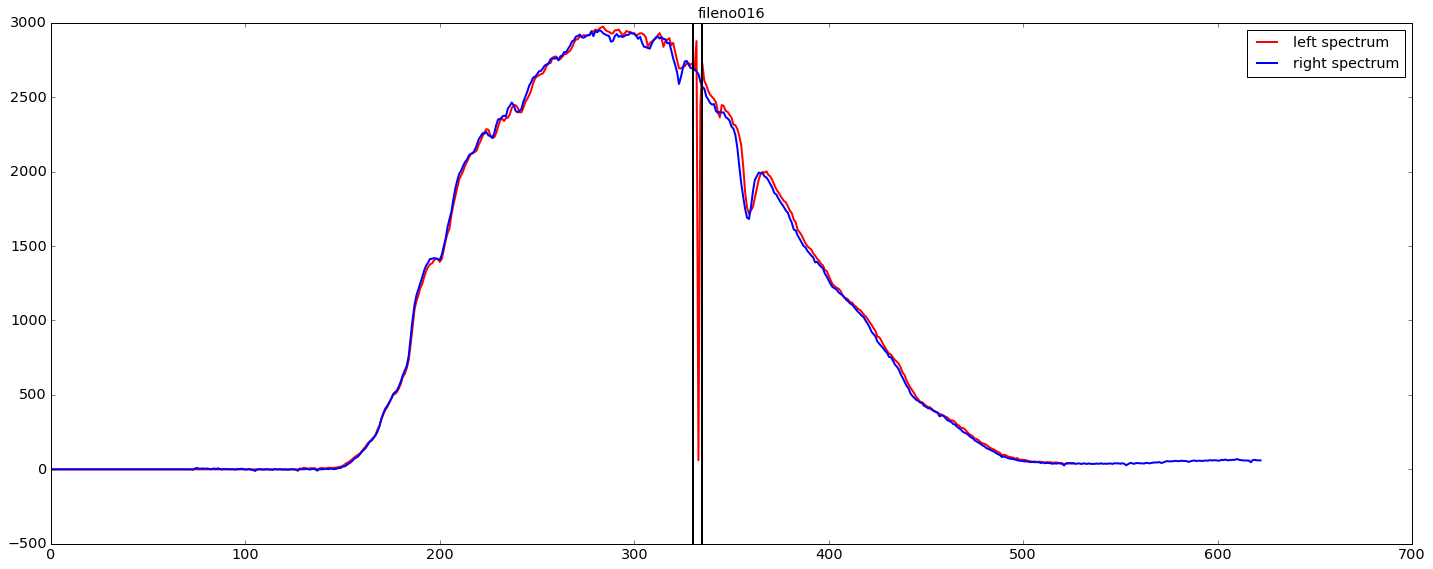

In [371]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(spec1,color='r',lw=2,label='left spectrum')
ax.plot(spec2,color='b',lw=2,label='right spectrum')
plt.title(object_name)
plt.legend(loc='best')
plt.tight_layout()
plt.plot([330,330],[-500,3000],'k-',lw=2)
plt.plot([335,335],[-500,3000],'k-',lw=2)

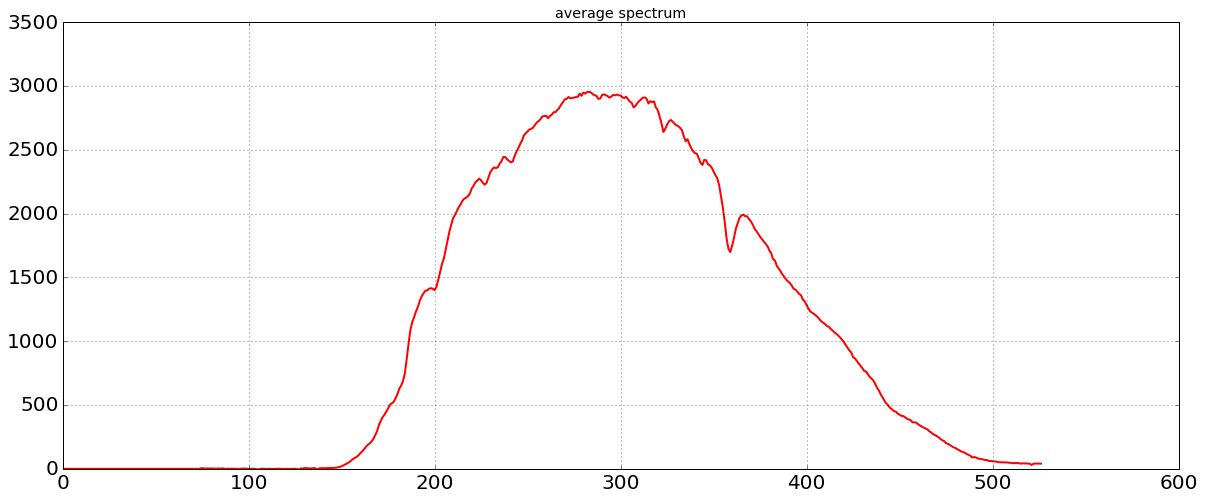

In [376]:
spec1[330:336]=spec2[330:336]  # remove bad pixel
N1=spec1.shape[0]
N2=spec2.shape[0]
N=np.min([N1,N2])
spec1_croped=spec1[0:N]
spec2_croped=spec2[0:N]
avspecsum=0.5*(spec1_croped+spec2_croped)
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(avspecsum,'r-',lw=2)
plt.ylim(0,3500)
plt.grid(True)
plt.title('average spectrum')